In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as tck
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import pandas as pd
import os

sns.set_theme()

In [28]:
# def plotData(file, nIter, title, colsToUse):
#     fig, (ax1,ax2) = plt.subplots(1,2)
#     fig.set_figheight(5)
#     fig.set_figwidth(15)
#     dataMaxMeans, dataMeanMeans = buildData(file, nIter, colsToUse)
#     xTicks = [2**i for i in range(len(dataMaxMeans))]
#     ax1.plot(xTicks, dataMaxMeans, label=dataMaxMeans.columns)
#     buildAx(title + " - Max time", xTicks, ax1)
#     ax2.plot(xTicks, dataMeanMeans, label=dataMeanMeans.columns)
#     buildAx(title + " - Mean time", xTicks, ax2)

# def plotDataStack(file, nIter, title, colsToUse):
#     fig, (ax1, ax2) = plt.subplots(1,2)
#     fig.set_figheight(8)
#     fig.set_figwidth(15)
#     dataMaxMeans, dataMeanMeans = buildData(file, nIter, colsToUse)
#     xTicks = [2**i for i in range(len(dataMaxMeans))]
#     ax1.stackplot(xTicks, dataMaxMeans.T, labels=dataMaxMeans.columns)
#     buildAx(title + " - Max time", xTicks, ax1)
#     ax2.stackplot(xTicks, dataMeanMeans.T, labels=dataMeanMeans.columns)
#     buildAx(title + " - Mean time", xTicks, ax2)
    
def plotDataStackBar(file, nIter, title, colsToUse):
    fig, (ax1) = plt.subplots(1,1)
    dataMaxMeans = buildData(file, nIter, colsToUse, True)
    #dataMeanMeans = buildData(file, nIter, colsToUse, False)
    buildAx(title + " - Max time", ax1, dataMaxMeans)
    #buildAx(title + " - Mean time", ax2, dataMeanMeans)
   
def buildData(file, nIter, colsToUse, isMax):
    data = pd.read_csv(file,header=0,sep=";")
    data = data[::2] if isMax else data[1::2]
    dataMeans = pd.DataFrame([data[i:i+nIter].mean() for i in range(0, len(data), nIter)])
    dataMeans = dataMeans[colsToUse]
    dataMeans = dataMeans.reindex(dataMeans.mean().sort_values(ascending=False).index, axis=1)
    return dataMeans
        
def buildAx(title, ax, data):
    xTicks = [2**i for i in range(len(data))] 
    ax.set_xscale("log", base=2)
    bar_data = np.array([data[col] for col in data.columns])
    widths = np.diff(xTicks + [xTicks[-1] * 2])*0.4
    ax.bar(xTicks, bar_data[0], widths, label=data.columns[0])
    for i in range(1, bar_data.shape[0]):
        ax.bar(xTicks, bar_data[i], widths, bottom=np.sum(bar_data[:i], axis=0), label=data.columns[i])
    xLabels = [str(i) for i in xTicks]
    ax.set_xticks(xTicks, xLabels)
    y_ticks = ax.get_yticks()
    ax.set_ylim(0, max(y_ticks))
    ax.set_xlabel("Number of MPI tasks")
    ax.set_ylabel("Time (s)")
    ax.set_title(title)
    ax.legend(loc="upper right", framealpha=0.7)
    # ax_twin = ax.twinx()
    # scalability = [[data[col].iloc[0] / data[col].iloc[j] for j in range(len(xTicks))] for col in data.columns]
    # for i in range(len(scalability)):
    #     ax_twin.plot(xTicks, scalability[i])
    # ax_twin.set_yticks(y_ticks)
    # maxScal = round(np.max(scalability)+0.01, 2)
    # y_ticks_scal = [maxScal/(len(y_ticks)-1)*i for i in range(len(y_ticks))]
    # ax_twin.set_ylim(0, maxScal)
    # ax_twin.set_yticks(y_ticks_scal)
    # ax_twin.grid(False)
    # ax_twin.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # ax_twin.set_ylabel('Scalability')
    ax.plot()


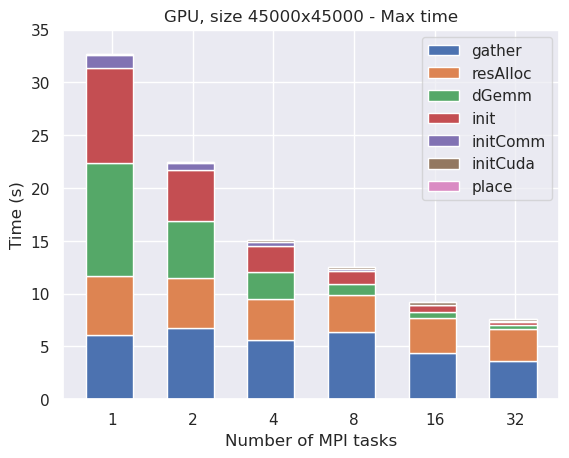

In [31]:
# "initCuda", "init", "initComm", "gather", "resAlloc", "dGemm", "place", "mult", "total"
colsToUse = [ "initCuda", "init", "initComm", "gather", "resAlloc", "dGemm", "place"]
size="45000"
plotDataStackBar("gpu"+size+".csv", 1, "GPU, size "+size+"x"+size, colsToUse)

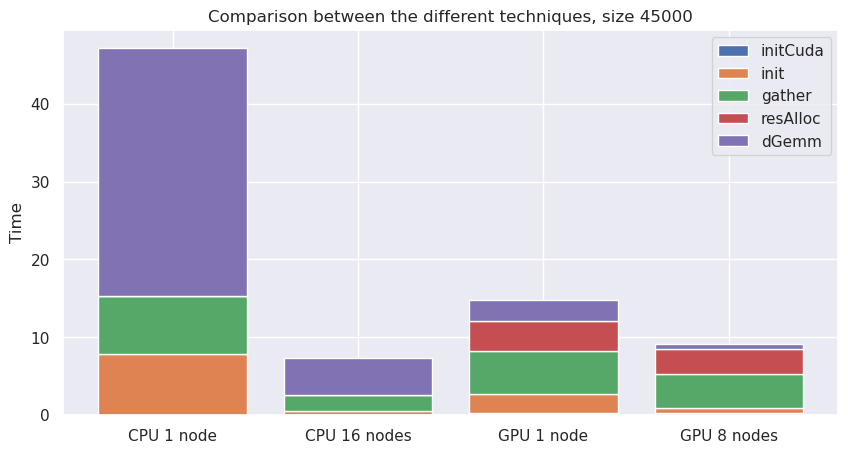

In [47]:
def read_data(files, cols_to_use):
    data_frames = []
    for file in files:
        df = pd.read_csv(file, usecols=cols_to_use, header=0, sep=";")
        data_frames.append(df)
    return data_frames

def plot_stack_bar(data_frames, titles):
    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(5)
    fig.set_figwidth(10) 
    #dataNaive1 = data_frames[0].loc[0].to_frame().T
    #dataNaive16 = data_frames[0].loc[8].to_frame().T
    datacpu1 = data_frames[0].loc[0].to_frame().T
    datacpu16 = data_frames[0].loc[8].to_frame().T
    datagpu1 = data_frames[1].loc[4].to_frame().T
    datagpu8 = data_frames[1].loc[8].to_frame().T
    dfs = [ datacpu1, datacpu16, datagpu1, datagpu8]
    # for d in dfs:
    #     print(d)
    combined_df = pd.concat(dfs, ignore_index=True)
    x_ticks = np.arange(len(dfs))
    bottom = np.zeros(combined_df.shape[0])
    for col in combined_df.columns:
        ax.bar(x_ticks, combined_df[col], bottom=bottom, width=0.8, label=col)
        bottom += combined_df[col]
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(titles)
    ax.set_ylabel("Time")
    ax.set_title("Comparison between the different techniques, size 45000")
    ax.legend(loc='upper right')
    plt.show()

size="45000"
files = [ 'cpu'+size+'.csv', 'gpu'+size+'.csv'] 
cols_to_use = ["initCuda", "init",  "gather", "resAlloc", "dGemm"] 
titles = [ 'CPU 1 node', 'CPU 16 nodes', 'GPU 1 node', 'GPU 8 nodes']

plot_stack_bar(read_data(files, cols_to_use), titles)